# Running GNN on real-world tracked data

In [4]:
%load_ext autoreload
%autoreload 2

from collab_env.data.file_utils import expand_path, get_project_root
import matplotlib.pyplot as plt
from rich import print

import pandas as pd
import pickle
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Current format consumed by the GNN

In [14]:
boid_dummy_data_fn = expand_path(
    "simulated_data/boid_single_species_basic.pt",
    get_project_root(),
)

boid_dummy_ds = torch.load(boid_dummy_data_fn, weights_only = False)
print(type(boid_dummy_ds))
p, sp = next(iter(boid_dummy_ds))
print(f"p.shape: {p.shape}, sp.shape: {sp.shape}")

<class 'collab_env.sim.boids_gnn_temp.animal_simulation.AnimalTrajectoryDataset'>

p.shape: torch.Size([800, 20, 2]), sp.shape: torch.Size([20])

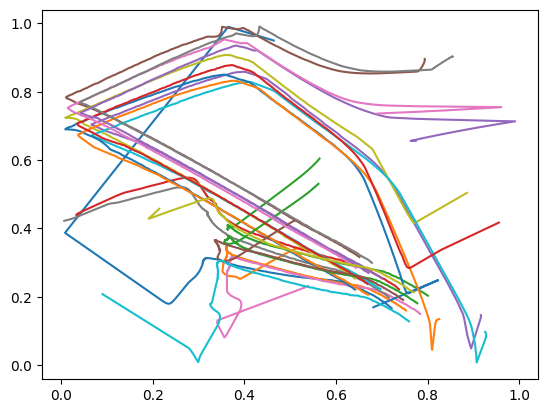

In [17]:
plt.figure()
plt.plot(p[..., 0], p[..., 1])
plt.show()

## The Data

In [18]:
real_data_fn = expand_path(
    "data/fieldwork_processed/2023_11_26-session_0001/aligned_frames/rgb_1/rgb_1_tracks.csv",
    get_project_root(),
)

real_data = pd.read_csv(real_data_fn)

print(real_data.head())

track_id  frame    x    y
0       1.0      0  448  232
1       1.0      1  437  236
2       1.0      2  434  242
3       1.0      3  430  250
4       1.0      4  430  260

In [29]:
# normalize x,y to [0,1] x [0,1]
real_data = real_data.assign(
    x_norm = lambda x: (x.x - x.x.min()) / (x.x.max() - x.x.min()),
    y_norm = lambda x: (x.y - x.y.min()) / (x.y.max() - x.y.min()),
)

In [59]:
max_seq_len = real_data.track_id.value_counts().max()
max_frame_id = real_data.frame.max() + 1
track_ids = real_data.track_id.unique()

print(f"max_seq_len: {max_seq_len}, track_ids: {len(track_ids)}")

all_tracks = torch.nan * torch.zeros(len(track_ids), max_frame_id, 2, dtype=torch.float64)
all_tracks_mask = torch.zeros(len(track_ids), max_frame_id, dtype=torch.bool)

for i, track_id in enumerate(track_ids):
    track = real_data[real_data.track_id == track_id]
    all_tracks[i, track.frame.astype(int).values, :] = torch.tensor(track[['x_norm', 'y_norm']].values)
    all_tracks_mask[i, track.frame.values] = True
    
print(f"all_tracks.shape: {all_tracks.shape}")

max_seq_len: 2233, track_ids: 210

all_tracks.shape: torch.Size([210, 9762, 2])

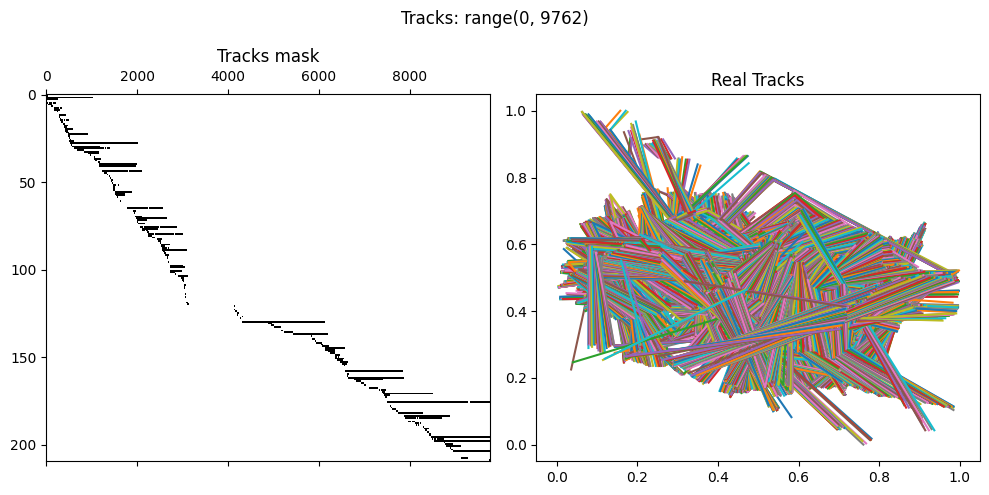

In [60]:
frame_rng = range(max_frame_id)
fix, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].spy(all_tracks_mask[...,frame_rng], aspect='auto')
ax[0].set_title("Tracks mask")
ax[1].plot(all_tracks[...,frame_rng, 0], all_tracks[...,frame_rng, 1])
ax[1].set_title("Real Tracks")
plt.suptitle(f"Tracks: {frame_rng}")
plt.tight_layout()
plt.show()